# Introdução

**Contextualização:**

O acesso à universidade é limitado e supõe-se altamente dependente de questões sócio-ecônomicas dos candidatos. Podemos classificar corretamente os perfis que vão para a faculdade?


Estes são dados sintéticos criados para um projeto de faculdade. Esses dados visam prever se os alunos continuarão a ir para a faculdade ou não. Com a explicabilidade do aprendizado de máquina, os orientadores escolares podem ajudar os alunos que não irão para a faculdade, encontrando o fator e ajudando-os. Vamos construir algo realmente útil. Aqui está meu caderno de recomendações.

Descrição do dataset:
* type_school: Tipo de escola que o aluno frequenta;
* school_accreditation: Quality of school (A is better than B);
* gender: Gênero do Aluno;
* interest: Quão interessados ​​estão os alunos se eles vão para a faculdade;
* residence: Tipo de residência;
* parent_age: Idade dos pais;
* parent_salary: Salário dos pais por mês em IDR/Rupia;
* house_area: Área da casa dos pais em metros quadrados;
* average_grades: Média das notas na escala de 0-100;
* parent_was_in_college: Os pais já estiveram na faculdade?;
* will_go_to_college: Previsões sobre ir para a faculdade, ou seja, o **Target**;


# 0. Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Métricas de avaliação do Modelo
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score,
                             confusion_matrix,
                             auc)


# Biblioteca que permitirá trabalhar com Redes Neurais
import tensorflow as tf
from tensorflow import keras

# 2. Importando o conjunto de dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
go_to_college = pd.read_csv('/content/drive/MyDrive/datasets/data.csv')

In [4]:
go_to_college.head(3)

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True


# 3. Análise Exploratória de Dados (EDA)

## 3.1 Exploração inicial

In [5]:
nrows, ncols = go_to_college.shape
print(f"N° de linhas: {nrows} \nN° de colunas: {ncols}")

N° de linhas: 1000 
N° de colunas: 11


In [6]:
go_to_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  will_go_to_college     1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 72.4+ KB


In [7]:
go_to_college.columns

Index(['type_school', 'school_accreditation', 'gender', 'interest',
       'residence', 'parent_age', 'parent_salary', 'house_area',
       'average_grades', 'parent_was_in_college', 'will_go_to_college'],
      dtype='object')

In [8]:
go_to_college[go_to_college.duplicated()]

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college


In [9]:
go_to_college.isna().sum() # Não há valores ausentes

,0
type_school,0
school_accreditation,0
gender,0
interest,0
residence,0
parent_age,0
parent_salary,0
house_area,0
average_grades,0
parent_was_in_college,0


In [10]:
# Transformando de booleando para inteiro
go_to_college['parent_was_in_college'] = go_to_college['parent_was_in_college'].map({False: 0, True: 1})
go_to_college['will_go_to_college'] = go_to_college['will_go_to_college'].map({False: 0, True: 1})

In [11]:
# Divisão treino x test
X = go_to_college.drop(['will_go_to_college'], axis=1)
y = go_to_college['will_go_to_college']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
X_train.shape, y_train.shape

((800, 10), (800,))

In [13]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)

## 3.2 Análise Univariada

In [14]:
limiar_uniques = 8
numerical_features = df_train.nunique()[(df_train.nunique() > limiar_uniques)].index.tolist()
categorical_features = df_train.nunique()[(df_train.nunique() <= limiar_uniques)].index.tolist()

print("Total Features:", len(categorical_features) + len(numerical_features))
print("Features Categóricas:", categorical_features)
print("Features Numéricas:", numerical_features)

Total Features: 11
Features Categóricas: ['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college', 'will_go_to_college']
Features Numéricas: ['parent_age', 'parent_salary', 'house_area', 'average_grades']


### 2.2.1 Features Numéricas

In [15]:
print(numerical_features)

['parent_age', 'parent_salary', 'house_area', 'average_grades']


In [16]:
print('Valores únicos \n==========================')
for feature in numerical_features:
  nuniques = df_train[feature].nunique()
  print(f'{feature}: {nuniques}')

Valores únicos 
parent_age: 25
parent_salary: 422
house_area: 416
average_grades: 589


In [17]:
# Resumo das variáveis
df_train[numerical_features].describe().round(2)  # Aparentemente, não há valores estranhos

,parent_age,parent_salary,house_area,average_grades
count,800.00,800.00,800.00,800.00
mean,52.19,5412375.00,74.55,86.14
std,3.52,1394410.39,15.04,3.39
min,40.00,1000000.00,20.40,75.00
25%,50.00,4410000.00,64.60,83.82
50%,52.00,5475000.00,75.40,85.66
75%,54.00,6440000.00,85.02,88.25
max,65.00,10000000.00,120.00,98.00


In [18]:
sns_graphics = {'boxenplot':sns.boxenplot, 'boxplot':sns.boxplot, 'viollini':sns.violinplot, 'kdeplot':sns.kdeplot}
plot_feature = [('parent_age', 'viollini'), ('parent_salary','kdeplot'), ('house_area','boxenplot'), ('average_grades', 'boxplot')]

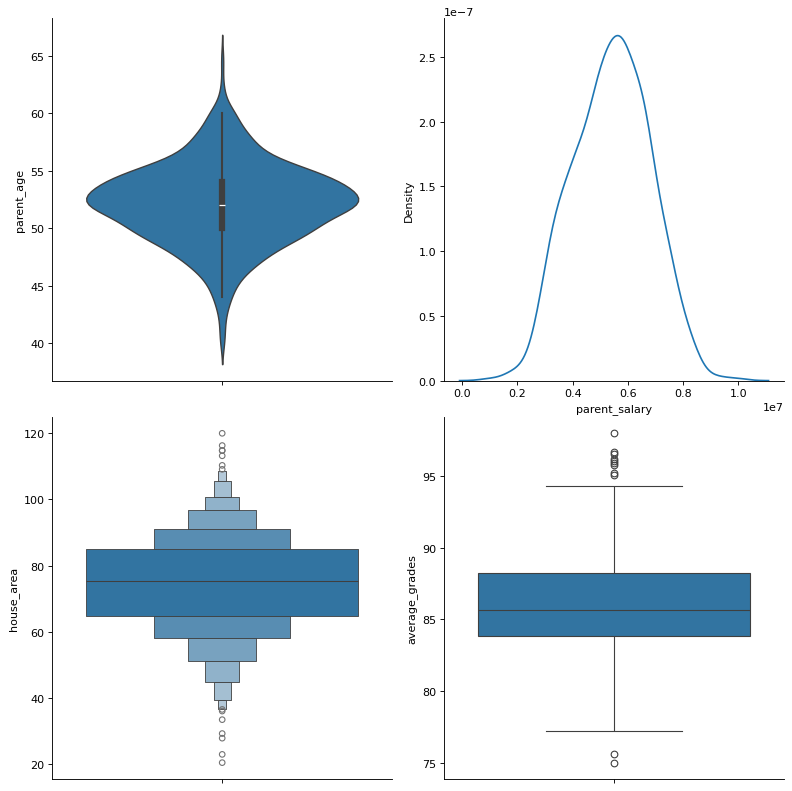

In [19]:
fig, axs = plt.subplots(2,2, figsize=(10,10), dpi=80)
axs = axs.flatten(order='C')

for i, (feature, grafic) in enumerate(plot_feature):
  if grafic.casefold() != "kdeplot":
    sns_graphics[grafic](data=df_train, y=feature, ax=axs[i])
  else:
    sns_graphics[grafic](data=df_train, x=feature, ax=axs[i])

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
sns.despine()

### 2.2.2 Features Categóricas

In [20]:
print(categorical_features)

['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college', 'will_go_to_college']


In [21]:
print('Valores únicos \n==========================')
for feature in categorical_features:
  nuniques = df_train[feature].nunique()
  uniques = df_train[feature].unique()
  print(f'{feature} ({nuniques}): {uniques}')

Valores únicos 
type_school (2): ['Academic' 'Vocational']
school_accreditation (2): ['B' 'A']
gender (2): ['Male' 'Female']
interest (5): ['Uncertain' 'Interested' 'Less Interested' 'Very Interested'
 'Not Interested']
residence (2): ['Urban' 'Rural']
parent_was_in_college (2): [1 0]
will_go_to_college (2): [1 0]


In [22]:
df_train['parent_was_in_college'] = df_train['parent_was_in_college'].astype('category')
df_train['will_go_to_college'] = df_train['will_go_to_college'].astype('category')

In [23]:
df_train[categorical_features].describe()

,type_school,school_accreditation,gender,interest,residence,parent_was_in_college,will_go_to_college
count,800,800,800,800,800,800,800
unique,2,2,2,5,2,2,2
top,Academic,B,Male,Very Interested,Urban,1,0
freq,493,410,407,263,441,410,400


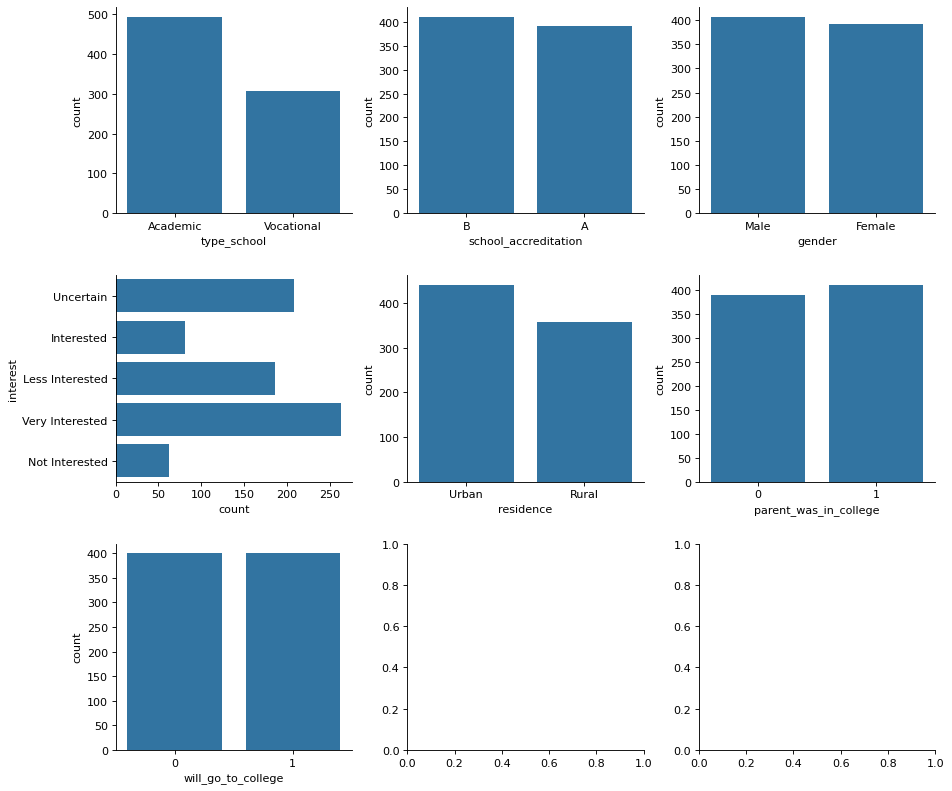

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10), dpi=80)
axs = axs.flatten(order='C')

for i, feature in enumerate(categorical_features):
    if feature != 'interest':
      sns.countplot(data=df_train, x=feature, ax=axs[i])
    else:
      sns.countplot(data=df_train, y=feature, ax=axs[i])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
sns.despine()
plt.show()

Insigths:
<hr>

1. Não sofremos com desbalanceamento das clases;
2. As variáveis numérica estão, aparetemente, bem distribídas;
3. Com exceção da  `interest` e `type_scool`, as demais variáveis estão bem equilibradas;


## 3.3 Análise Bivariada

In [25]:
sns_graphics = {'boxenplot':sns.boxenplot, 'boxplot':sns.boxplot, 'viollini':sns.violinplot, 'kdeplot':sns.kdeplot}
plot_feature = [('parent_age', 'viollini'), ('parent_salary','viollini'), ('house_area','boxenplot'), ('average_grades', 'boxplot')]

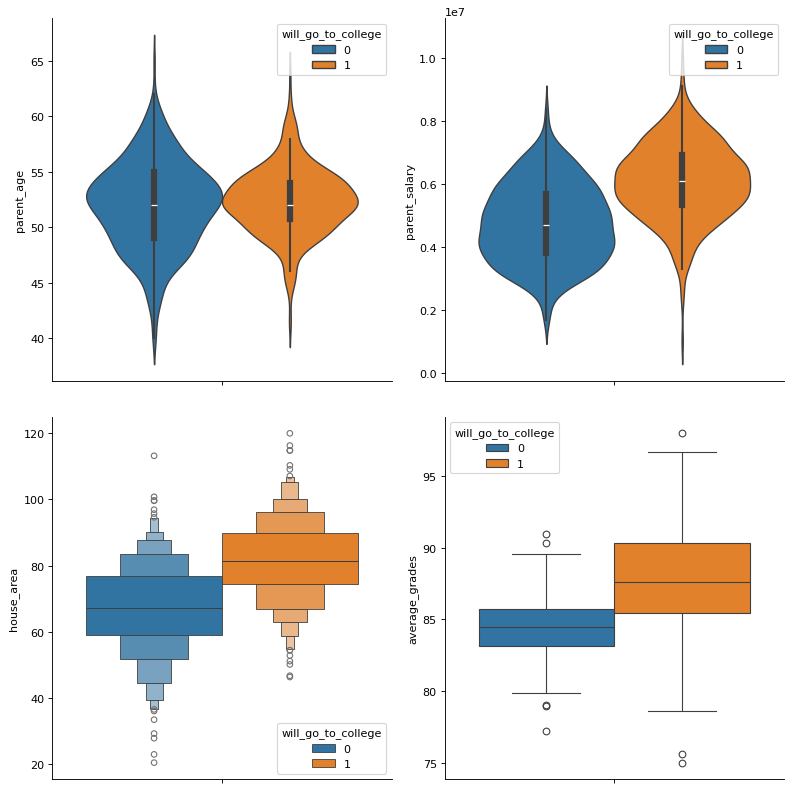

In [26]:
fig, axs = plt.subplots(2,2, figsize=(10,10), dpi=80)
axs = axs.flatten(order='C')

for i, (feature, grafic) in enumerate(plot_feature):
  if grafic.casefold() != "kdeplot":
    sns_graphics[grafic](data=df_train, y=feature, ax=axs[i], hue='will_go_to_college')
  else:
    sns_graphics[grafic](data=df_train, x=feature, ax=axs[i], hue='will_go_to_college')

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
sns.despine()

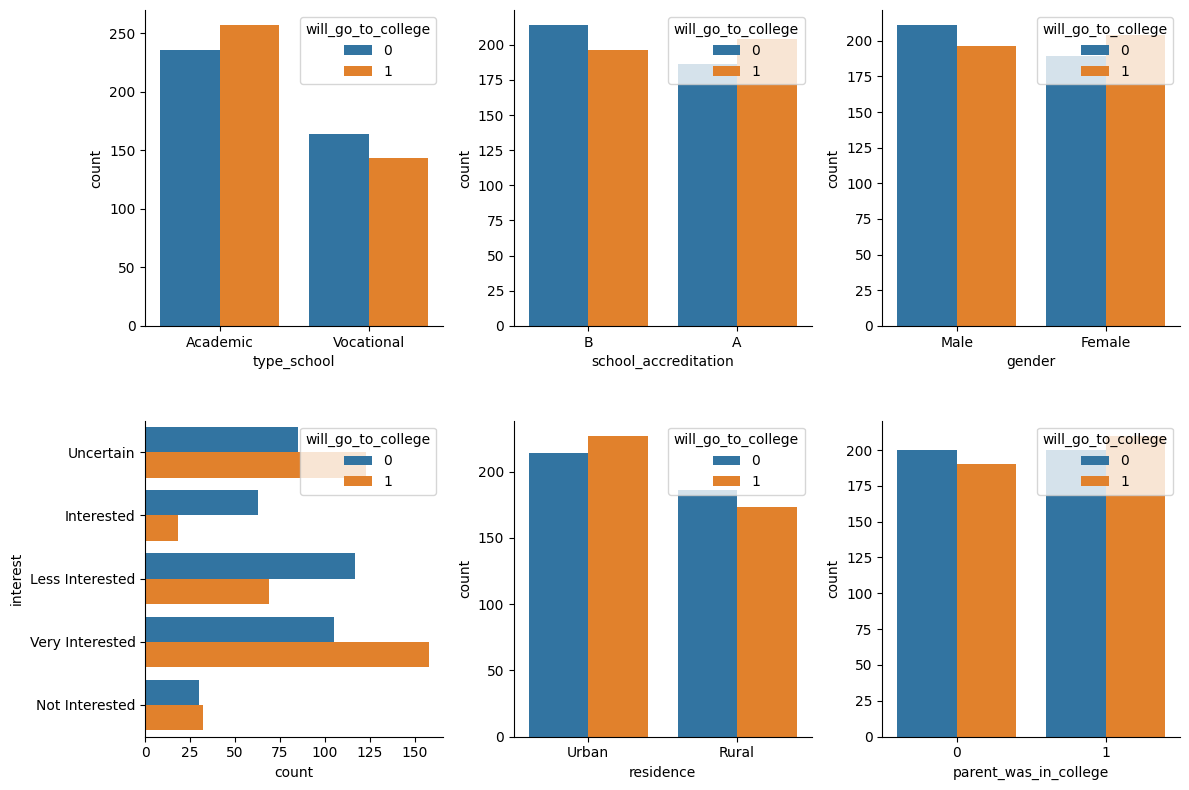

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), dpi=100)
axs = axs.flatten(order='C')

for i, feature in enumerate(categorical_features):
    if (feature != 'interest') and (feature != 'will_go_to_college'):
      sns.countplot(data=df_train, x=feature, ax=axs[i], hue='will_go_to_college')
    else:
      if feature == 'interest':
        sns.countplot(data=df_train, y=feature, ax=axs[i], hue='will_go_to_college')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
sns.despine()
plt.show()

Insigths:
1. Aparentemente, as pessoas que frequêntaram a faculdade possuem uma nota média boa, moram em casas maiores e seus pais tem um salário bom;
2. Grande parte dos alunos que tinham um forte interesse, grande maioria deles frequetaram a faculdade. Curiosamente, os alunos que estavam incerto, a maior parte deles frequêntou a faculdade.
3. Por outro, dos alunos que tinham um leve interesse ou pouco interesse, sua maior parte não frequentaram a faculdade;
4. As pessoas que tendem a frequêntar a faculdade possui as seguintes características:
  - frequêntou escola acadêmica;
  - Frequêntou escola do nível A;
  - São do gênero fêmino;
  - possui residência urbana;
  - teve um parente que frequêntou à faculdade;


# 4. Pré-processamento dos dados

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 739 to 503
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            800 non-null    object 
 1   school_accreditation   800 non-null    object 
 2   gender                 800 non-null    object 
 3   interest               800 non-null    object 
 4   residence              800 non-null    object 
 5   parent_age             800 non-null    int64  
 6   parent_salary          800 non-null    int64  
 7   house_area             800 non-null    float64
 8   average_grades         800 non-null    float64
 9   parent_was_in_college  800 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 101.0+ KB


In [29]:
categorical_features = ['type_school','school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college']
numerical_features = ['parent_age', 'parent_salary', 'house_area', 'average_grades']

In [30]:
# Transfomando em categórica para não ter problema ao usar o ColumnTransformer
X_train['parent_was_in_college'] = X_train['parent_was_in_college'].astype('category')
X_test['parent_was_in_college'] = X_test['parent_was_in_college'].astype('category')

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['parent_age', 'parent_salary', 'house_area',
                                  'average_grades']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['type_school', 'school_accreditation',
                                  'gender', 'interest', 'residence',
                                  'parent_was_in_college'])])

In [32]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# 5. Modelagem

In [110]:
# Definindo o número de folds
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Para armazenar o desempenho de cada fold
rocauc_scores = []
acc_scores = []

print(f'+++++ Validação Cruzada (k = {n_splits}) +++++')
for i, (train_index, val_index) in enumerate(kf.split(X_train_transformed, y_train.values)):
    # Dividir em treino e validação
    X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

    # Criar o modelo
    model = keras.models.Sequential([
        keras.layers.Input(shape=X_train_transformed.shape[1:]),
        keras.layers.Dense(15, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")  # Saída binária com ativação sigmoid
    ])

    # Compilar o modelo
    model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

    # Treinar o modelo
    model.fit(X_train_fold, y_train_fold, epochs=20, verbose=0)

    # Realizar previsões
    y_val_pred_proba = model.predict(X_val_fold, verbose=0).flatten()

    # Calcular a métrica de AUC-ROC
    rocauc = roc_auc_score(y_val_fold, y_val_pred_proba)
    acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]

    rocauc_scores.append(rocauc)
    acc_scores.append(acc)
    print(f'+ ({i+1}/{n_splits}) fold {i+1} - Done')

# covert to array
rocauc_scores_arr = np.array(rocauc_scores)
acc_scores_arr = np.array(acc_scores)

print('\n=============== SCORE CROSS VALIDATION ===============')
print(f'ROC AUC Scores: {rocauc_scores_arr.round(4)}')
print(f'Accuracy Scores: {acc_scores_arr.round(4)}')

print()
print(f'ROC AUC mean: {rocauc_scores_arr.mean():.4f} +/- {rocauc_scores_arr.std():.4f}')
print(f'Accuracy mean: {acc_scores_arr.mean():.4f} +/- {acc_scores_arr.std():.4f}')

# Treinando o modelo sobre todo o conjunto de dados
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train_transformed.shape[1:]),
    keras.layers.Dense(15, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")])
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.fit(X_train_transformed, y_train.values, epochs=20, verbose=0)

y_pred_proba = model.predict(X_test_transformed, verbose=0).flatten()
y_pred = y_pred_proba > 0.5

rocauc_teste = roc_auc_score(y_test, y_pred_proba)
acc_teste = model.evaluate(X_test_transformed, y_test.values, verbose=0)[1]

print('\n================ SCORE DADOS DE TESTE ================')
print(f"ROC AUC Score: {roc_auc_score(y_test.values, y_pred_proba):.2%}")
print(f"Accuracy Score: {accuracy_score(y_test.values, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test.values, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test.values, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test.values, y_pred):.2%}")

+++++ Validação Cruzada (k = 5) +++++
+ (1/5) fold 1 - Done
+ (2/5) fold 2 - Done
+ (3/5) fold 3 - Done
+ (4/5) fold 4 - Done
+ (5/5) fold 5 - Done

=============== SCORE CROSS VALIDATION ===============
ROC AUC Scores: [0.907  0.8989 0.8795 0.9008 0.8684]
Accuracy Scores: [0.8375 0.8    0.8062 0.8125 0.7875]

ROC AUC mean: 0.8909 +/- 0.0145
Accuracy mean: 0.8087 +/- 0.0166

================ SCORE DADOS DE TESTE ================
ROC AUC Score: 89.86%
Accuracy Score: 82.00%
Precision Score: 85.56%
Recall Score: 77.00%
F1 Score: 81.05%
